In [1]:
import numpy as np
import pandas as pd
from river import optim
from river.drift import ADWIN
from ray.tune.sklearn import TuneGridSearchCV
from sail.models.river.forest import AdaptiveRandomForestClassifier
from sail.models.river.linear_model import LogisticRegression
from sail.models.auto_ml.auto_pipeline import SAILAutoPipeline
from sail.pipeline import SAILPipeline
from sklearn.impute import SimpleImputer
import ray.cloudpickle as cpickle
from sail.transfomers.river.preprocessing import StandardScaler

#### Load Data

In [2]:
df = pd.read_csv("../../datasets/agrawal.csv").head(50000)
X = df.copy()

y = X["class"]
X.drop("class", axis=1, inplace=True)


#### Model Definition

In [3]:
logistic_reg = LogisticRegression(optimizer=optim.SGD(0.1))
random_forest = AdaptiveRandomForestClassifier(n_models=10)

#### Create SAIL Pipeline

In [4]:
steps = [
    ("Imputer", SimpleImputer(missing_values=np.nan, strategy="mean")),
    ("standard_scalar", StandardScaler()),
    ("classifier", "passthrough"),
]
sail_pipeline = SAILPipeline(steps=steps)

[2023-06-12 18:55:55:676] - INFO - SAIL : created SAILPipeline object with ID 6df0b2fe-caab-4b3a-ad2f-859e6387285b


#### HPO Params

In [5]:
params_grid = [
    {
        "classifier": [logistic_reg],
        "classifier__l2": [0.1, 0.9],
        "classifier__intercept_init": [0.2, 0.5],
    },
    {
        "classifier": [random_forest],
        "classifier__n_models": [5, 10],
        "Imputer": ["passthrough"],
    },
]

#### Create Model Instance

In [6]:
auto_pipeline = SAILAutoPipeline(
    pipeline=sail_pipeline,
    pipeline_params_grid=params_grid,
    search_data_size=1000,
    search_method=TuneGridSearchCV,
    search_method_params={
        "max_iters": 1,
        "early_stopping": False,
        "mode": "max",
        "scoring": "accuracy",
        "pipeline_auto_early_stop": False,
    },
    drift_detector=ADWIN(delta=0.001),
    pipeline_strategy="DetectAndIncrement"
)

[2023-06-12 18:55:55:722] - INFO - SAIL : Pipeline Strategy [DetectAndIncrement] created with actions: ['DATA_COLLECTION', 'FIND_BEST_PIPELINE', 'SCORE_AND_DETECT_DRIFT', 'PARTIAL_FIT_MODEL']


#### Start Training

In [7]:
y_preds = []
y_true = []
batch_size = 50

start = 0
for end in range(50, 2001, batch_size):

    X_train = X.iloc[start:end]
    y_train = y.iloc[start:end]

    if end > 1000: # search_data_size is 1000
        preds = auto_pipeline.predict(X_train)
        y_preds.extend(list(preds))
        y_true.extend(list(y_train))

    auto_pipeline.train(X_train, y_train)
    start = end


2023-06-12 18:55:59,162	WARNING searcher.py:377 -- save not implemented for Searcher. Skipping save.
(_TuneSklearnTrainable pid=4911) [2023-06-12 18:56:01:192] - INFO - SAIL : created SAILPipeline object with ID ac8b25fe-5b84-433f-b367-210c90c6ffc3
(_TuneSklearnTrainable pid=4911) [2023-06-12 18:56:01:192] - INFO - SAIL : created SAILPipeline object with ID 4466daff-4c14-4d0a-9c10-b83e53a6d08e
(_TuneSklearnTrainable pid=4911) [2023-06-12 18:56:01:193] - INFO - SAIL : created SAILPipeline object with ID 75a01b91-f1b0-4bf3-9ecc-7130da074723
(_TuneSklearnTrainable pid=4911) [2023-06-12 18:56:01:193] - INFO - SAIL : created SAILPipeline object with ID 8a1ced45-9580-456a-9bc8-4879d15866d6
(_TuneSklearnTrainable pid=4911) [2023-06-12 18:56:01:193] - INFO - SAIL : created SAILPipeline object with ID 49255734-8526-4c04-a366-31c2a8d6a8c1
(_TuneSklearnTrainable pid=4911) [2023-06-12 18:56:01:224] - INFO - SAIL : created SAILPipeline object with ID 7362e4b0-969f-4028-9cfc-6ed6f389c4f8
(_TuneSklea

(_TuneSklearnTrainable pid=4911) [Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
(_TuneSklearnTrainable pid=4911) [Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s


2023-06-12 18:56:02,896	INFO tensorboardx.py:269 -- Removed the following hyperparameter values when logging to tensorboard: {'classifier': AdaptiveRandomForestClassifier()}
2023-06-12 18:56:04,532	INFO tensorboardx.py:269 -- Removed the following hyperparameter values when logging to tensorboard: {'classifier': AdaptiveRandomForestClassifier()}
[2023-06-12 18:56:04:571] - INFO - SAIL : created SAILPipeline object with ID b4d5ae84-a355-48d7-a3be-36281ad0b822
[2023-06-12 18:56:04:573] - INFO - SAIL : created SAILPipeline object with ID 50690bd1-844c-4296-acaf-0537a38176ea
[2023-06-12 18:56:05:328] - INFO - SAIL : Cumulative Pipeline Score: 0.92
[2023-06-12 18:56:05:342] - INFO - SAIL : Cumulative Pipeline Score: 0.96
[2023-06-12 18:56:05:357] - INFO - SAIL : Cumulative Pipeline Score: 0.9266666666666666
[2023-06-12 18:56:05:372] - INFO - SAIL : Cumulative Pipeline Score: 0.93
[2023-06-12 18:56:05:389] - INFO - SAIL : Cumulative Pipeline Score: 0.908
[2023-06-12 18:56:05:404] - INFO - SA

[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.7s


[2023-06-12 18:56:05:528] - INFO - SAIL : Cumulative Pipeline Score: 0.9142857142857143
[2023-06-12 18:56:05:544] - INFO - SAIL : Cumulative Pipeline Score: 0.916
[2023-06-12 18:56:05:560] - INFO - SAIL : Cumulative Pipeline Score: 0.9175
[2023-06-12 18:56:05:575] - INFO - SAIL : Cumulative Pipeline Score: 0.9176470588235294
[2023-06-12 18:56:05:590] - INFO - SAIL : Cumulative Pipeline Score: 0.9188888888888889
[2023-06-12 18:56:05:606] - INFO - SAIL : Cumulative Pipeline Score: 0.92
[2023-06-12 18:56:05:622] - INFO - SAIL : Cumulative Pipeline Score: 0.923


In [8]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_true, y_preds))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       652
           1       0.94      0.83      0.88       348

    accuracy                           0.92      1000
   macro avg       0.93      0.90      0.91      1000
weighted avg       0.92      0.92      0.92      1000



<Axes: >

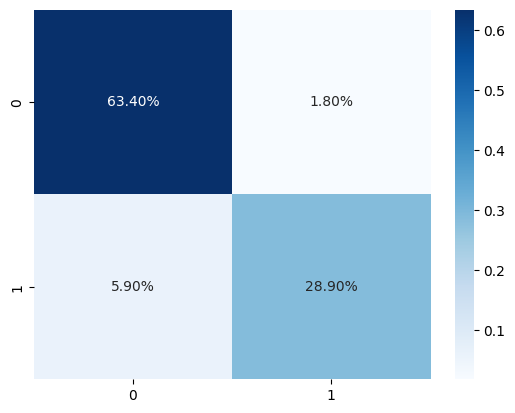

In [9]:
import seaborn as sns

cf_matrix = confusion_matrix(y_true, y_preds)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')